In [1]:
import cupy as cp
import numpy as np

from cuda import cudart

from pyproj import Transformer
from cuproj import Transformer as cuTransformer

import timeit

import matplotlib.pyplot as plt

In [2]:
# San Francisco bounding box
min_corner = (37.7081, -122.5149)
max_corner = (37.8324, -122.3573)
crs_from = "EPSG:4326"
crs_to = "EPSG:32610"

In [3]:
def run_pyproj(num_points):
    grid_side = int(np.sqrt(num_points))
    transformer = Transformer.from_crs(crs_from, crs_to)

    x, y = np.meshgrid(np.linspace(min_corner[0], max_corner[0], grid_side),
                       np.linspace(min_corner[1], max_corner[1], grid_side))

    grid = [x.reshape(-1), y.reshape(-1)]

    t = timeit.Timer(lambda: transformer.transform(*grid))
    return t.autorange()

def cu_run_and_sync(transformer, grid):
  transformer.transform(*grid)
  cudart.cudaDeviceSynchronize()

def run_cuproj(num_points):
    grid_side = int(np.sqrt(num_points))
    transformer = cuTransformer.from_crs(crs_from, crs_to)

    x, y = cp.meshgrid(cp.linspace(min_corner[0], max_corner[0], grid_side),
                       cp.linspace(min_corner[1], max_corner[1], grid_side))

    grid = [x.reshape(-1), y.reshape(-1)]

    t = timeit.Timer(lambda: cu_run_and_sync(transformer, grid))
    return t.autorange()

def run_cuproj_host_data(num_points):
    grid_side = int(np.sqrt(num_points))
    transformer = cuTransformer.from_crs(crs_from, crs_to)

    x, y = np.meshgrid(np.linspace(min_corner[0], max_corner[0], grid_side),
                       np.linspace(min_corner[1], max_corner[1], grid_side))

    grid = [x.reshape(-1), y.reshape(-1)]

    t = timeit.Timer(lambda: cu_run_and_sync(transformer, grid))
    return t.autorange()

In [6]:
num_points = np.geomspace(100, 1e8, 7).astype(int)

throughput_pyproj = []
throughput_cuproj = []
throughput_cuproj_host_data = []

# pyproj
for n in num_points:
    iters, time = run_pyproj(n)
    throughput_pyproj.append(n / (time / iters))
    
# cuproj data on device
for n in num_points:
    iters, time = run_cuproj(n)
    throughput_cuproj.append(n / (time / iters))

# cuproj including host to device copy
for n in num_points:
    iters, time = run_cuproj_host_data(n)
    throughput_cuproj_host_data.append(n / (time / iters))

grid_side: 10
grid_side: 31
grid_side: 100
grid_side: 316
grid_side: 1000
grid_side: 3162
grid_side: 10000


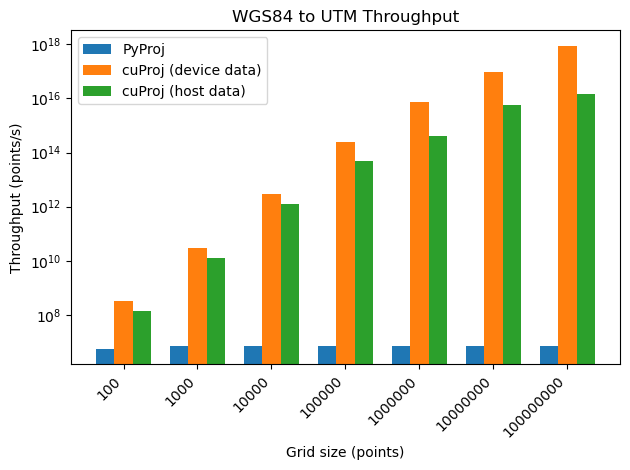

In [5]:
mean_throughputs = {'PyProj': throughput_pyproj, 
          'cuProj (device data)': throughput_cuproj,
          'cuProj (host data)': throughput_cuproj_host_data}

x = np.arange(len(num_points))
width = 0.25

fig, ax = plt.subplots()

ax.set_yscale('log')
ax.set_ylabel('Throughput (points/s)')
ax.set_xlabel('Grid size (points)')
ax.set_title('WGS84 to UTM Throughput')
ax.set_xticks(x)
ax.set_xticklabels(num_points)
ax.set_xticklabels(num_points, rotation=45, ha='right')

for i, label in enumerate(mean_throughputs.keys()):
  rects = ax.bar(x + (i - 1) * width, mean_throughputs[label], width, label=label)

ax.legend()
fig.tight_layout()
plt.show()


32.0

In [20]:
np.geomspace(100, 1e8, 7)

array([1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08])